# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
adjacency = np.load('data/adjacency_sym_mtx.npy')  

# set diagonal to zero, to remove the self-loop as in previous milestones
adjacency[np.diag_indices_from(adjacency)] = 0

In [4]:
def grad(adjacency):
    n_edges = int(np.sum(adjacency)/2)
    n_nodes = int(adjacency.shape[0])
    
    s = np.zeros((n_nodes, n_edges))
    
    current_edge = 0
    
    for i in range(n_nodes):
        for k in range(i):
            if adjacency[i,k] > 0 :
                s[i,current_edge] = 1
                s[k, current_edge] = 1
                current_edge += 1
                
    return s.T

In [5]:
import pandas as pd
nodes = pd.read_csv('data/nodes.csv')

In [6]:
laplacian = sparse.csgraph.laplacian(adjacency, normed=False) # choose combinatorial uppon advise of assistant
gradient = grad(adjacency)

# For this milestone, we have chosen the labels as "South" (-1) or "North" (1)
# depending on the sign of the latitude
labels = nodes["Latitude"].apply(lambda x: -1 if x < 0 else 1).values[:-25]

n_nodes = adjacency.shape[0]

In [7]:
# Extracting Largest connected component
import networkx as nx
G = nx.from_numpy_matrix(adjacency)
Gc = max(nx.connected_component_subgraphs(G), key=len)
adjacency_c = np.array(nx.to_numpy_matrix(Gc))
n_nodes_c = nx.number_of_nodes(Gc)
laplacian_c_comb = sparse.csgraph.laplacian(adjacency_c, normed=False).astype('float64')
laplacian_c_norm = sparse.csgraph.laplacian(adjacency_c, normed=True)
laplacian_c = laplacian_c_comb
grad_c = grad(adjacency_c)

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [8]:
e, U = scipy.linalg.eigh(laplacian_c)

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

In [9]:
import pygsp as pg
graph1 = pg.graphs.Graph(adjacency_c)
graph2 = pg.graphs.Graph(adjacency_c)

In [10]:
graph1.set_coordinates(U[:, 1:3])  # Laplacian eigenmaps.
graph2.set_coordinates('spring')  # Force-directed layout.

Text(0.5, 1.0, 'last eigenvector')

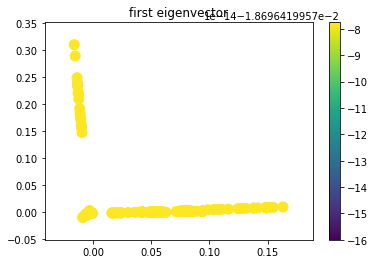

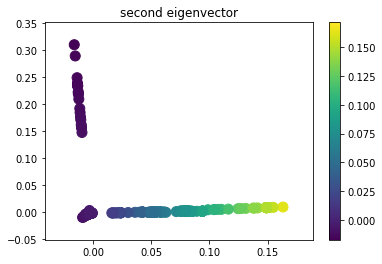

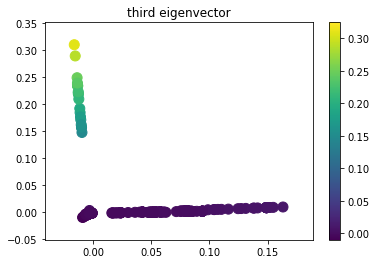

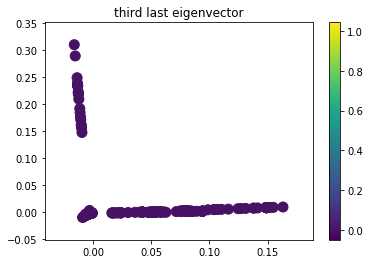

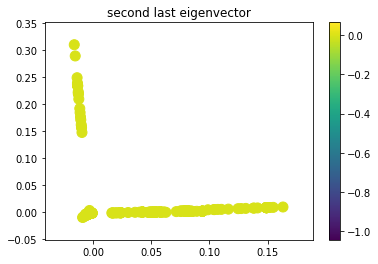

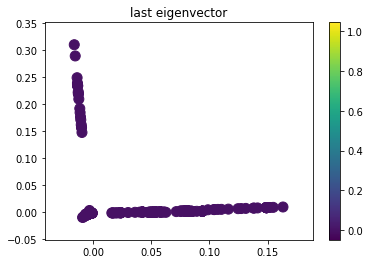

In [11]:
v_size = 100
graph1.plot_signal(U[:, 0], vertex_size = v_size)
plt.title("first eigenvector")
graph1.plot_signal(U[:, 1], vertex_size = v_size)
plt.title("second eigenvector")
graph1.plot_signal(U[:, 2], vertex_size = v_size)
plt.title("third eigenvector")
graph1.plot_signal(U[:, -3], vertex_size = v_size)
plt.title("third last eigenvector")
graph1.plot_signal(U[:, -2], vertex_size = v_size)
plt.title("second last eigenvector")
graph1.plot_signal(U[:, -1], vertex_size = v_size)
plt.title("last eigenvector")

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

We can see that the magnitude of the first eigenvectors are stronger than the last ones. Indeed, all three last are pretty close to 0. That means that the first eigenvectors express in a better way the axis where our graph has stronger variations. We can interpret these eigenvalues (related to their eigenvectors) as  how much information they carry, therefore they are linked with the frequency domain, because the more information carried, the higher the frequency.

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [12]:
def GFT(x):
    return U.T.dot(x)

def iGFT(x):
    return U.dot(x)

### Question 4

Plot your feature/label vector as a signal on your graph

Text(0.5, 1.0, 'labels as signal, spring')

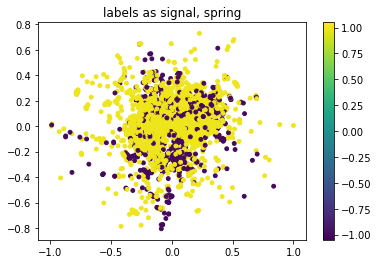

In [13]:
graph2.plot_signal(labels, vertex_size=15)
plt.title("labels as signal, spring")

Text(0.5, 1.0, 'labels as signals, eigenmap')

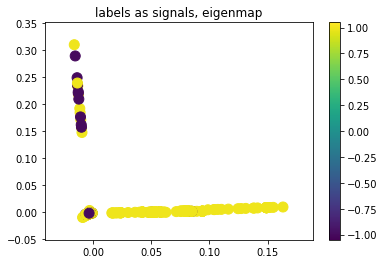

In [14]:
graph1.plot_signal(labels, vertex_size = v_size)
plt.title("labels as signals, eigenmap")

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

Text(0, 0.5, 'Graph Fourier Transform')

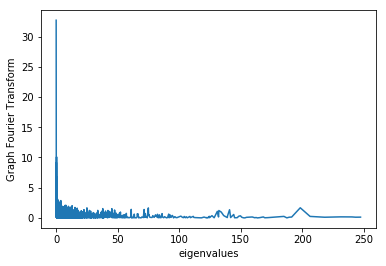

In [15]:
plt.plot(e, np.abs(GFT(labels)))
plt.xlabel("eigenvalues")
plt.ylabel("Graph Fourier Transform")

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

Overall, the absolute value of the graph fourier transform of our labels is very high for small eigenvalues and decreases fast as we go to higher frequencies. This indicates it correspond to a low-pass signal, if we convolve it with another signal it will remove high frequencies and let lower ones.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [16]:
def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    return np.diag(np.linalg.inv(np.identity(n_nodes_c) + t*np.diag(e)))

def rectangle_kernel(e, l_min, l_max):
    f = np.vectorize(lambda x: 1.0 if x >= l_min and x <= l_max else 0.0)
    return f(e)

def graph_filter(x, kernel, **kwargs):    
    return iGFT(GFT(x) * kernel(e=e, **kwargs))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

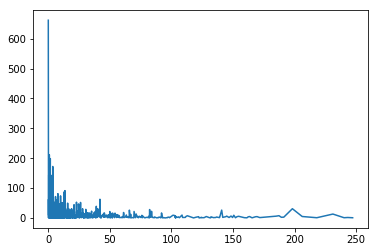

In [17]:
#plt.plot(heat_kernel(e,t=5))


# AUR
heat = graph_filter(e, heat_kernel,  t=-0.005)
plt.plot(e, np.abs(GFT(heat)))

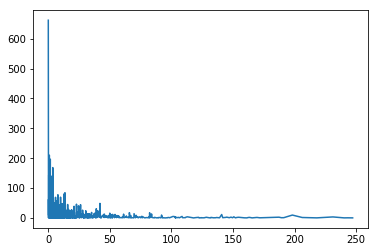

In [18]:
#plt.plot(inverse_kernel(e, t=5))

# AUR
inverse = graph_filter(e, inverse_kernel,  t=0.001)
plt.plot(e, np.abs(GFT(inverse)))

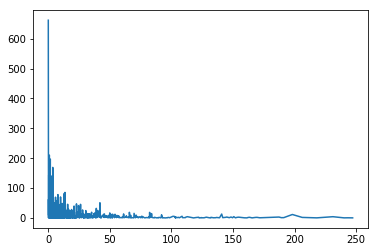

In [19]:
#plt.plot(rectangle_kernel(e, 0, 1))

rectangle = graph_filter(e, rectangle_kernel,l_min = 0, l_max = 250)
plt.plot(e, np.abs(GFT(rectangle)))

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [20]:
dirac1 = np.zeros(n_nodes_c)

max_connected_node = np.argmax(np.sum(adjacency_c, axis = 1))

dirac1[max_connected_node]=1

heat1 = graph_filter(dirac1, heat_kernel, t=2)
inverse1 = graph_filter(dirac1, inverse_kernel, t=2)
rectangle1 = graph_filter(dirac1, rectangle_kernel, l_min=0.0, l_max = 0.2)

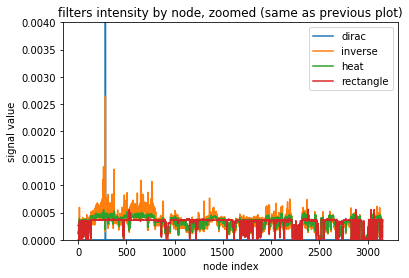

In [21]:
plt.plot(dirac1)
plt.plot(inverse1)
plt.plot(heat1)
plt.plot(rectangle1)

plt.ylim([0,0.004])
plt.title("filters intensity by node, zoomed (same as previous plot)")
plt.xlabel("node index")
plt.ylabel("signal value")
plt.legend(["dirac", "inverse", "heat", "rectangle"])

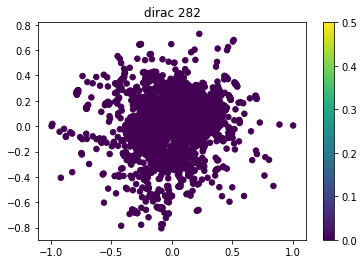

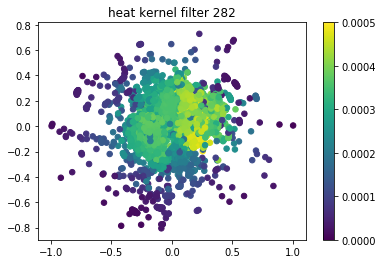

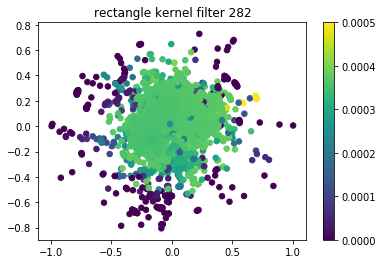

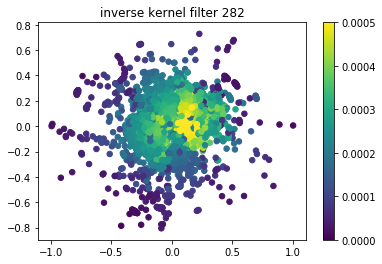

In [22]:
size = 30
graph2.plot_signal(dirac1, limits=[0, 0.5], vertex_size=size, plot_name="dirac 282")#, highlight=[3000, 2470])
graph2.plot_signal(heat1, limits=[0,0.0005], vertex_size=size, plot_name="heat kernel filter 282")#, highlight=heat_hl)
graph2.plot_signal(rectangle1, limits=[0,0.0005], vertex_size=size, plot_name="rectangle kernel filter 282")#, show_edges=True)#, highlight=rectangle_hl)
graph2.plot_signal(inverse1, limits=[0,0.0005], vertex_size=size, plot_name="inverse kernel filter 282")#, highlight=inverse_hl)

In [108]:
# Your code here.
dirac2 = np.zeros(n_nodes_c)
#dirac2[3000]=1
#dirac2[2470]=1
#dirac2[2676]=1
#dirac2[2688]=1
#dirac2[2695]=1
#dirac2[6]=1

#dirac2[2737]=1

dirac2[3100]=1

#dirac2[2541]=1


heat2 = graph_filter(dirac2, heat_kernel, t=2)
inverse2 = graph_filter(dirac2, inverse_kernel, t=2)
rectangle2 = graph_filter(dirac2, rectangle_kernel, l_min=0.0, l_max = 0.2)

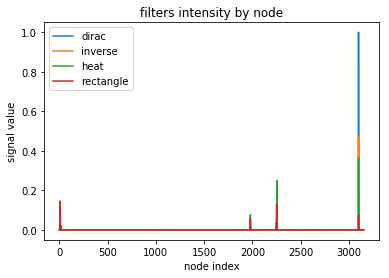

In [109]:
plt.plot(dirac2)
plt.plot(inverse2)
plt.plot(heat2)
plt.plot(rectangle2)
plt.title("filters intensity by node")
plt.xlabel("node index")
plt.ylabel("signal value")
plt.legend(["dirac", "inverse", "heat", "rectangle"])

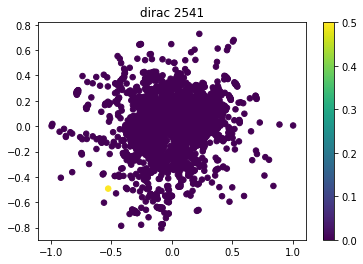

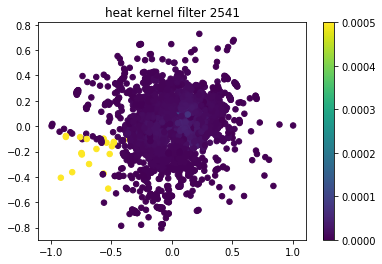

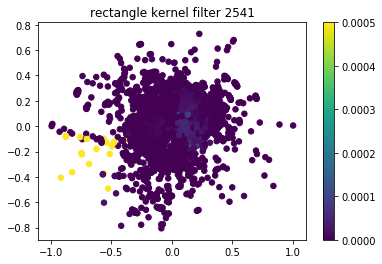

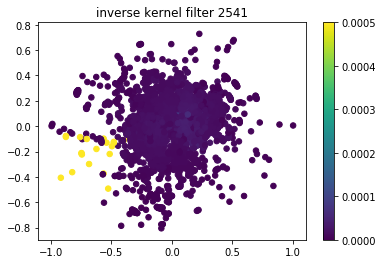

In [110]:
size = 30
graph2.plot_signal(dirac2, limits=[0, 0.5], vertex_size=size, plot_name="dirac 2541")#, highlight=[3000, 2470])
graph2.plot_signal(heat2, limits=[0,0.0005], vertex_size=size, plot_name="heat kernel filter 2541")#, highlight=heat_hl)
graph2.plot_signal(rectangle2, limits=[0,0.0005], vertex_size=size, plot_name="rectangle kernel filter 2541")#, show_edges=True)#, highlight=rectangle_hl)
graph2.plot_signal(inverse2, limits=[0,0.0005], vertex_size=size, plot_name="inverse kernel filter 2541")#, highlight=inverse_hl)

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Answer :** <br>
The first dirac was chosen to correpond to the most connected node (the one with highest degree). We see clearly on the plots that applying the filter to this dirac propagates the impulse almost everywhere on the graph. When applying it to a random node, spread is much more local and not on the whole graph. <br>

The rectangle filter propagates the impulse uniformly around the dirac, whereas the inverse kernel propagates it in a way which is very concentrated around the source and gradually to other connected nodes. The heat kernel is intermediary between the two.

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [28]:
noise_var = np.var(labels) /1.5
noisy_measurements = labels + np.sqrt(noise_var) * np.random.randn(n_nodes_c)

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Your answer here.**

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [87]:
z_heat_denoised =  graph_filter(noisy_measurements , heat_kernel,  t=0.15)
z_inv_denoised = graph_filter(noisy_measurements , inverse_kernel,  t=0.35)
z_rect_denoised =  graph_filter(noisy_measurements , rectangle_kernel,  l_min = 0, l_max = 1.0)

diff_inv = labels - z_inv_denoised
diff_heat = labels - z_heat_denoised
diff_rect = labels - z_rect_denoised


Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

relative error noisy:  0.6698935306519634
relative error heat:  0.5262103205688368
relative error rect:  0.6305068863479213
relative error inv:  0.506257993830549


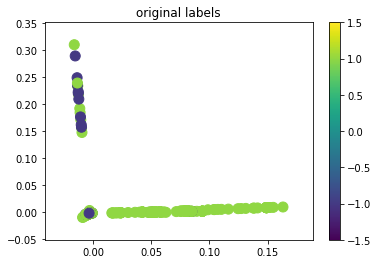

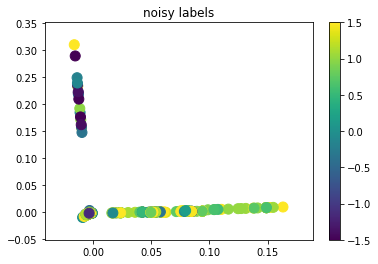

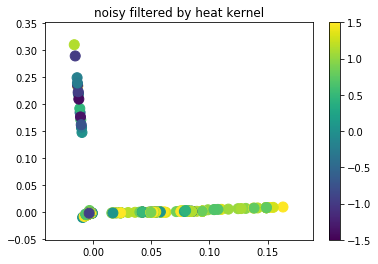

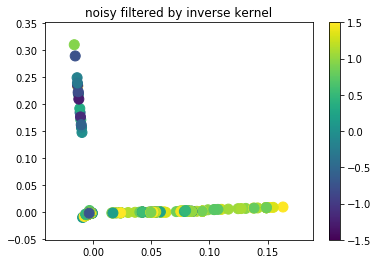

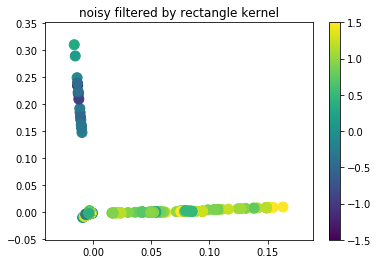

In [88]:
def rel_err(z):
    return np.linalg.norm(z - labels) / np.linalg.norm(labels)

print("relative error noisy: ", rel_err(noisy_measurements) )
print("relative error heat: ", rel_err(z_heat_denoised) )
print("relative error rect: ", rel_err(z_rect_denoised) )
print("relative error inv: ", rel_err(z_inv_denoised) )

graph1.plot_signal(labels, limits=[-1.5,1.5], plot_name = "original labels")

graph1.plot_signal(noisy_measurements, limits=[-1.5,1.5], plot_name = "noisy labels")

graph1.plot_signal(z_heat_denoised, limits=[-1.5,1.5], plot_name = "noisy filtered by heat kernel")

graph1.plot_signal(z_inv_denoised, limits=[-1.5,1.5], plot_name = "noisy filtered by inverse kernel")

graph1.plot_signal(z_rect_denoised, limits=[-1.5,1.5], plot_name = "noisy filtered by rectangle kernel")


Finally, overlay on the same plot the GFT of all five signals above.

Text(0, 0.5, 'GFT')

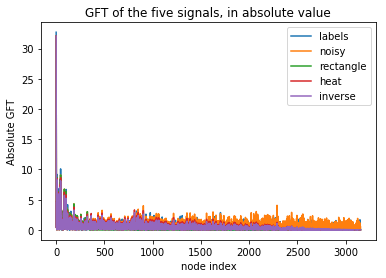

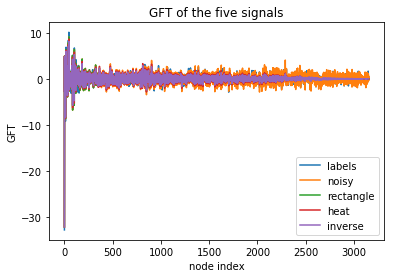

In [94]:
plt.figure(1)
for signal in (labels, noisy_measurements,z_rect_denoised, z_heat_denoised,  z_inv_denoised):  # z_inv_denoised 
    plt.plot(np.abs(GFT(signal)))
  
plt.legend(["labels", "noisy", "rectangle", "heat", "inverse"])
plt.title("GFT of the five signals, in absolute value")
plt.xlabel("node index")
plt.ylabel("Absolute GFT")
 
plt.figure(2)
for signal in (labels, noisy_measurements, z_rect_denoised, z_heat_denoised, z_inv_denoised):  # z_inv_denoised 
    plt.plot(GFT(signal))

plt.legend(["labels", "noisy", "rectangle", "heat", "inverse"])
plt.title("GFT of the five signals")
plt.xlabel("node index")
plt.ylabel("GFT")

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Answer:**
From the graph obersevations, we would say that the signal filtered by the heat kernel or the rectangle kernel matches best the original signal. This is confirmed and precised by the relative error computations : the rectangle kernel filtering is the one which works best. <br>
The underlying assumption behind the three filtering approaches is that the original signal which we try to recover should be **smooth**. <br>

The results we got are **not very satisfying**, with a minimum relative error around 0.526 with the heat kernel, 0.506 with the inverse kernel and 0.630 with the rectangle one, whereas the relative error with the noisy measurement is 0.67, so quite close. <br>

Therefore we would say that our label signal is **not so smooth**. <br>


## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [95]:
labels_bin = labels

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [96]:
def get_w(mn_ratio=0.3):
    m = int(mn_ratio * n_nodes_c)  # Number of measurements.

    idx_chosen = np.random.choice(n_nodes_c, m, False)

    w = np.zeros(n_nodes_c)
    w[idx_chosen]=1.0
    return w

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


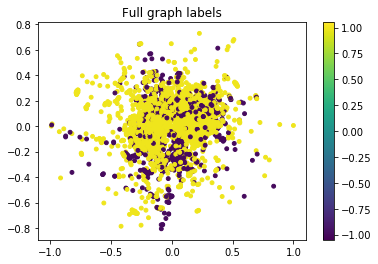

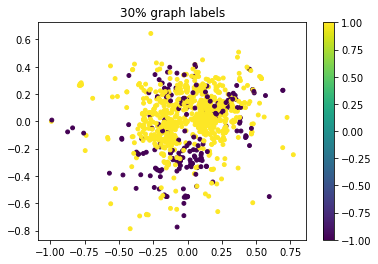

In [100]:
w = get_w()
w_plot = w.copy()
w_plot[w_plot == 0] = np.nan

graph2.plot_signal(labels, vertex_size= 15, plot_name = "Full graph labels")
graph2.plot_signal(w_plot * labels, vertex_size = 15, limits = [-1.0,1.0], plot_name = "30% graph labels")

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [101]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p
      
    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [102]:
def P(a):  
    b = labels * w + (1 - w) * a
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [103]:

x0 = np.random.randn(grad_c.shape[1])
sol_1norm_min = graph_pnorm_interpolation(sparse.csr_matrix(grad_c), P, x0=x0, p=1)

sol_2norm_min = graph_pnorm_interpolation(sparse.csr_matrix(grad_c), P, x0=x0, p=2)

threshold = 0


# already defined above, but copied for clarity
def binarize(arr, threshold = 0):
    b =  arr.copy()
    mask = b < threshold
    not_mask = b >= threshold
    b[mask] = -1
    b[not_mask] = 1
    return b

sol_1norm_bin = binarize(sol_1norm_min, threshold)

sol_2norm_bin = binarize(sol_2norm_min, threshold) 

Solution found after 35 iterations:
    objective function f(sol) = 5.660209e+04
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 6.690334e+04
    stopping criterion: MAXIT


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [104]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    
    pt_matrix = np.zeros((len(thresholds), len(mn_ratios)))
    
    for i, threshold in enumerate(thresholds):
        for j, ratio in enumerate(mn_ratios):
            for n in range(n_trials):
                
                rel_errs = []

                # Create sample mask.
                w = get_w(mn_ratio=ratio)
                
                # Solve p-norm interpolation.
                P = lambda a: labels * w + (1 - w) * a

                sol_norm_min = graph_pnorm_interpolation(sparse.csr_matrix(grad_c), P, x0=x0, p=p)
                sol_norm_bin = binarize(sol_norm_min, threshold)

                err = rel_err(sol_norm_bin)
                rel_errs.append(err)
                
            # Aggregate.
            pt_matrix[i, j] = np.array(rel_errs).mean()
       
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [105]:
mn_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
thresholds = [-0.8, -0.4, 0, 0.4, 0.8] 

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, 10, labels_bin, p=1)
pt_matrix_2norm = phase_transition(mn_ratios, thresholds, 10, labels_bin, p=2)


Solution found after 66 iterations:
    objective function f(sol) = 5.776299e+04
    stopping criterion: RTOL
Solution found after 38 iterations:
    objective function f(sol) = 7.387842e+04
    stopping criterion: RTOL
Solution found after 41 iterations:
    objective function f(sol) = 9.367799e+04
    stopping criterion: RTOL
Solution found after 42 iterations:
    objective function f(sol) = 9.889836e+04
    stopping criterion: RTOL
Solution found after 42 iterations:
    objective function f(sol) = 1.023375e+05
    stopping criterion: RTOL
Solution found after 43 iterations:
    objective function f(sol) = 1.049564e+05
    stopping criterion: RTOL
Solution found after 44 iterations:
    objective function f(sol) = 1.056372e+05
    stopping criterion: RTOL
Solution found after 44 iterations:
    objective function f(sol) = 1.064471e+05
    stopping criterion: RTOL
Solution found after 44 iterations:
    objective function f(sol) = 1.058547e+05
    stopping criterion: RTOL
Solution f

Solution found after 41 iterations:
    objective function f(sol) = 7.157691e+04
    stopping criterion: RTOL
Solution found after 42 iterations:
    objective function f(sol) = 7.066340e+04
    stopping criterion: RTOL
Solution found after 10 iterations:
    objective function f(sol) = 3.164625e+04
    stopping criterion: RTOL
Solution found after 33 iterations:
    objective function f(sol) = 6.645166e+04
    stopping criterion: RTOL
Solution found after 41 iterations:
    objective function f(sol) = 6.860448e+04
    stopping criterion: RTOL
Solution found after 39 iterations:
    objective function f(sol) = 5.759428e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 5.773208e+04
    stopping criterion: RTOL
Solution found after 38 iterations:
    objective function f(sol) = 5.674402e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 5.360934e+04
    stopping criterion: RTOL
Solution f

Solution found after 30 iterations:
    objective function f(sol) = 1.115970e+05
    stopping criterion: RTOL
Solution found after 38 iterations:
    objective function f(sol) = 1.280334e+05
    stopping criterion: RTOL
Solution found after 71 iterations:
    objective function f(sol) = 7.487033e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 9.366889e+04
    stopping criterion: RTOL
Solution found after 111 iterations:
    objective function f(sol) = 6.137320e+04
    stopping criterion: RTOL
Solution found after 82 iterations:
    objective function f(sol) = 5.204312e+04
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 9.259496e+04
    stopping criterion: RTOL
Solution found after 43 iterations:
    objective function f(sol) = 1.015199e+05
    stopping criterion: RTOL
Solution found after 44 iterations:
    objective function f(sol) = 1.016205e+05
    stopping criterion: RTOL
Solution 

Solution found after 43 iterations:
    objective function f(sol) = 6.743474e+04
    stopping criterion: RTOL
Solution found after 39 iterations:
    objective function f(sol) = 6.803161e+04
    stopping criterion: RTOL
Solution found after 43 iterations:
    objective function f(sol) = 6.847410e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 7.017268e+04
    stopping criterion: RTOL
Solution found after 42 iterations:
    objective function f(sol) = 6.760091e+04
    stopping criterion: RTOL
Solution found after 42 iterations:
    objective function f(sol) = 5.604766e+04
    stopping criterion: RTOL
Solution found after 8 iterations:
    objective function f(sol) = 3.232458e+04
    stopping criterion: RTOL
Solution found after 34 iterations:
    objective function f(sol) = 5.698310e+04
    stopping criterion: RTOL
Solution found after 9 iterations:
    objective function f(sol) = 3.127016e+04
    stopping criterion: RTOL
Solution fou

Solution found after 200 iterations:
    objective function f(sol) = 2.173046e+04
    stopping criterion: MAXIT
Solution found after 200 iterations:
    objective function f(sol) = 1.600313e+04
    stopping criterion: MAXIT
Solution found after 200 iterations:
    objective function f(sol) = 1.385835e+04
    stopping criterion: MAXIT
Solution found after 200 iterations:
    objective function f(sol) = 1.232571e+04
    stopping criterion: MAXIT
Solution found after 194 iterations:
    objective function f(sol) = 1.171838e+04
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.590654e+04
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.223735e+04
    stopping criterion: MAXIT
Solution found after 2 iterations:
    objective function f(sol) = 1.614340e+04
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.348103e+04
    stopping criterion: MAXIT

Solution found after 177 iterations:
    objective function f(sol) = 3.669802e+04
    stopping criterion: RTOL
Solution found after 171 iterations:
    objective function f(sol) = 3.607442e+04
    stopping criterion: RTOL
Solution found after 159 iterations:
    objective function f(sol) = 3.742837e+04
    stopping criterion: RTOL
Solution found after 192 iterations:
    objective function f(sol) = 3.404182e+04
    stopping criterion: RTOL
Solution found after 153 iterations:
    objective function f(sol) = 3.562099e+04
    stopping criterion: RTOL
Solution found after 174 iterations:
    objective function f(sol) = 3.561743e+04
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 5.605362e+04
    stopping criterion: RTOL
Solution found after 150 iterations:
    objective function f(sol) = 4.797196e+04
    stopping criterion: RTOL
Solution found after 125 iterations:
    objective function f(sol) = 4.791547e+04
    stopping criterion: RTOL
Sol

Solution found after 20 iterations:
    objective function f(sol) = 6.324528e+04
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 2.103212e+04
    stopping criterion: MAXIT
Solution found after 200 iterations:
    objective function f(sol) = 1.602283e+04
    stopping criterion: MAXIT
Solution found after 200 iterations:
    objective function f(sol) = 1.382420e+04
    stopping criterion: MAXIT
Solution found after 194 iterations:
    objective function f(sol) = 1.308237e+04
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.174937e+04
    stopping criterion: MAXIT
Solution found after 2 iterations:
    objective function f(sol) = 1.537474e+04
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.285629e+04
    stopping criterion: MAXIT
Solution found after 200 iterations:
    objective function f(sol) = 1.142206e+04
    stopping criterion: MAXI

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

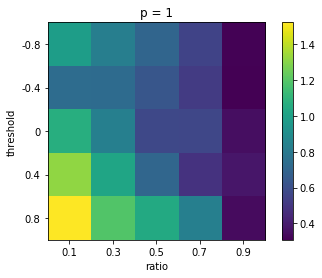

In [106]:
plt.imshow(pt_matrix_1norm)
plt.title("p = 1")
plt.xlabel("ratio")
plt.ylabel("threshold")
plt.xticks(range(len(mn_ratios)), mn_ratios)
plt.yticks(range(len(thresholds)), thresholds)
plt.colorbar()
plt.show()

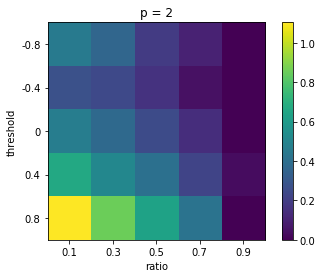

In [107]:
plt.imshow(pt_matrix_2norm)
plt.title("p = 2")
plt.xlabel("ratio")
plt.ylabel("threshold")
plt.xticks(range(len(mn_ratios)), mn_ratios)
plt.yticks(range(len(thresholds)), thresholds)
plt.colorbar()
plt.show()

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**answer:** <br>
If we want to minimize the relative error, one can see that of course this error is minimized by taking the higher the ratio (with the trade off of asking more about the graph, which wants to be avoided), but an interesting thing is that L1 norm shows in a better way which threshold is more appropriate. <br>
This makes sense with the theory to use L1 norm to select features of a given model in Machine Learning for example, where L2 norm would be use to do the prediction itself (Ridge Regression). <br>
The idea behind is that L1 norm will gives more importance to some "labels?" and almost nothing to others while L2 just tries to minimize the overall and keeps a bit of importance of each "labels?" everywhere, which is not the thing needed here, Because we want to know if our subsample has low error.